In [31]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
from scipy import stats
import matplotlib
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)

In [32]:
path_to_save = "../results/Figures/Supplemental Figure 1/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [33]:
kang = sc.read("../data/train_pbmc.h5ad")
kang

AnnData object with n_obs × n_vars = 16893 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [34]:
kang.obs.groupby(['condition', 'cell_type']).size()

condition   cell_type  
control     CD4T           2437
            CD14+Mono      1946
            B               818
            CD8T            574
            NK              517
            FCGR3A+Mono    1100
            Dendritic       615
stimulated  CD4T           3127
            CD14+Mono       615
            B               993
            CD8T            541
            NK              646
            FCGR3A+Mono    2501
            Dendritic       463
dtype: int64

In [37]:
hpoly = sc.read("../data/train_hpoly.h5ad")
hpoly

AnnData object with n_obs × n_vars = 5059 × 7000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts', 'n_genes', 'mt_frac'
    var: 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_label_colors', 'condition_colors', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [40]:
hpoly.obs.groupby(['condition', 'cell_label']).size()

condition    cell_label           
Control      Endocrine                 93
             Enterocyte               361
             Enterocyte.Progenitor    466
             Goblet                   184
             Stem                     556
             TA                       357
             TA.Early                 666
             Tuft                      53
Hpoly.Day10  Endocrine                 70
             Enterocyte               106
             Enterocyte.Progenitor    517
             Goblet                   272
             Stem                     492
             TA                       305
             TA.Early                 366
             Tuft                     195
dtype: int64

In [41]:
salmonella = sc.read("../data/train_salmonella.h5ad")
salmonella

AnnData object with n_obs × n_vars = 4259 × 7000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts', 'n_genes', 'mt_frac'
    var: 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_label_colors', 'condition_colors', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [42]:
salmonella.obs.groupby(['condition', 'cell_label']).size()

condition   cell_label           
Control     Endocrine                 98
            Enterocyte               367
            Enterocyte.Progenitor    466
            Goblet                   190
            Stem                     570
            TA                       350
            TA.Early                 676
            Tuft                      48
Salmonella  Endocrine                 62
            Enterocyte               594
            Enterocyte.Progenitor    198
            Goblet                   103
            Stem                     174
            TA                        95
            TA.Early                 250
            Tuft                      18
dtype: int64

In [48]:
def plot_binary_classifiers(adata, data_name, cell_type, conditions, cell_type_key):
    network = scgen.VAEArith(x_dimension=adata.shape[1], model_path=f"../models/scGen/{data_name}/{cell_type}/scgen")
    network.restore_model()
    unperturbed_data = adata[((adata.obs[cell_type_key] == cell_type) & (adata.obs["condition"] == conditions["ctrl"]))]
    net_train_data = adata[~((adata.obs[cell_type_key] == cell_type) & (adata.obs["condition"] == conditions["stim"]))]
    print(net_train_data.obs.groupby([cell_type_key, 'condition']).size())
    pred, delta = network.predict(adata=net_train_data, 
                                  adata_to_predict=unperturbed_data, 
                                  conditions=conditions,
                                  cell_type_key=cell_type_key,
                                  condition_key="condition")
    scgen.plotting.binary_classifier(network, adata, delta, condition_key="condition",
                                     conditions=conditions,
                                     fontsize=18,
                                     path_to_save=os.path.join(path_to_save, f"SupplFig1b_{data_name}_{cell_type}.pdf"))

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/CD4T/scgen
cell_type    condition 
CD4T         control       2437
CD14+Mono    control       1946
             stimulated     615
B            control        818
             stimulated     993
CD8T         control        574
             stimulated     541
NK           control        517
             stimulated     646
FCGR3A+Mono  control       1100
             stimulated    2501
Dendritic    control        615
             stimulated     463
dtype: int64


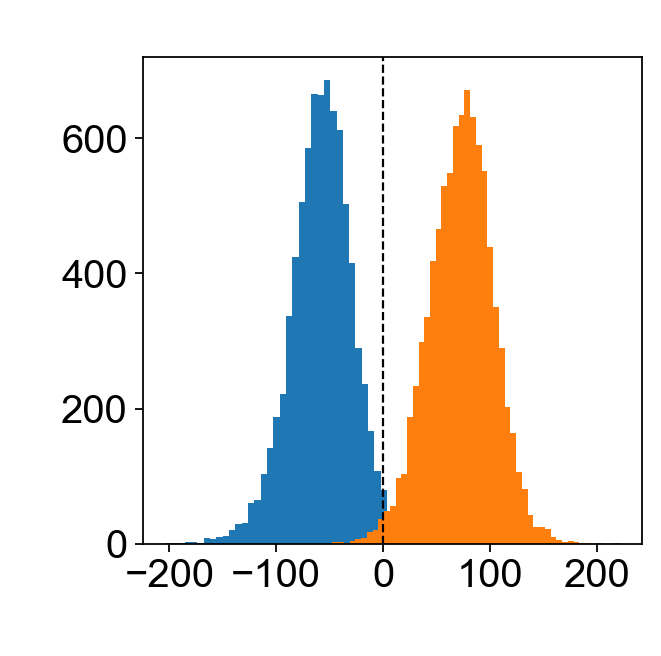

In [49]:
conditions = {"ctrl": "control", "stim": "stimulated"}
plot_binary_classifiers(kang, "pbmc", "CD4T", conditions, "cell_type")

INFO:tensorflow:Restoring parameters from ../models/scGen/hpoly/TA.Early/scgen
cell_label             condition  
Endocrine              Control         93
                       Hpoly.Day10     70
Enterocyte             Control        361
                       Hpoly.Day10    106
Enterocyte.Progenitor  Control        466
                       Hpoly.Day10    517
Goblet                 Control        184
                       Hpoly.Day10    272
Stem                   Control        556
                       Hpoly.Day10    492
TA                     Control        357
                       Hpoly.Day10    305
TA.Early               Control        666
Tuft                   Control         53
                       Hpoly.Day10    195
dtype: int64


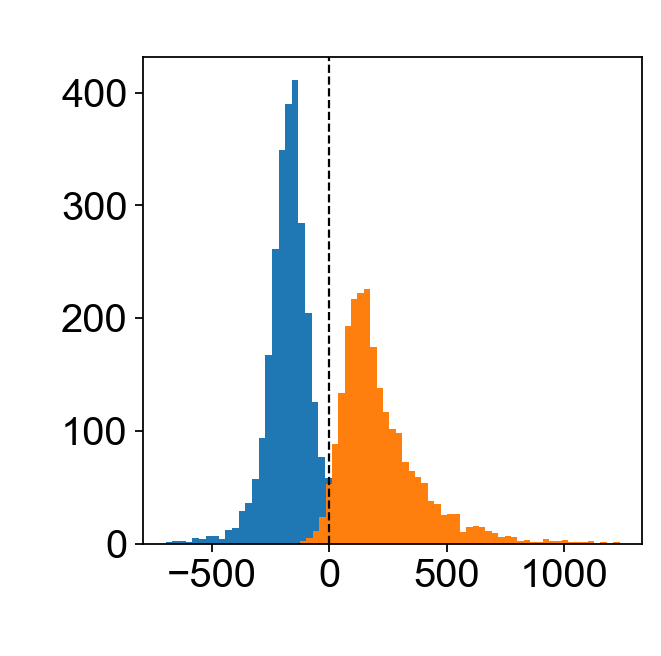

In [50]:
conditions = {"ctrl": "Control", "stim": "Hpoly.Day10"}
plot_binary_classifiers(hpoly, "hpoly", "TA.Early", conditions, "cell_label")

INFO:tensorflow:Restoring parameters from ../models/scGen/salmonella/Endocrine/scgen
cell_label             condition 
Endocrine              Control        98
Enterocyte             Control       367
                       Salmonella    594
Enterocyte.Progenitor  Control       466
                       Salmonella    198
Goblet                 Control       190
                       Salmonella    103
Stem                   Control       570
                       Salmonella    174
TA                     Control       350
                       Salmonella     95
TA.Early               Control       676
                       Salmonella    250
Tuft                   Control        48
                       Salmonella     18
dtype: int64


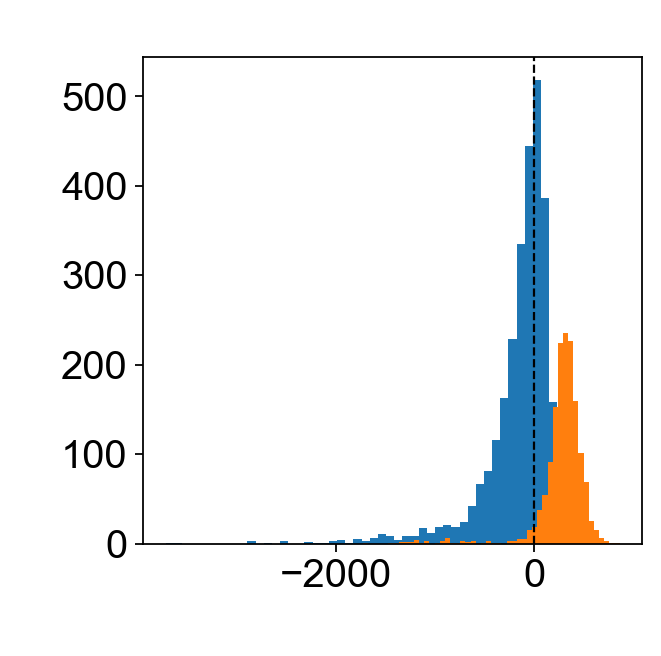

In [51]:
conditions = {"ctrl": "Control", "stim": "Salmonella"}
plot_binary_classifiers(salmonella, "salmonella", "Endocrine", conditions, "cell_label")

In [57]:
train_data = sc.read("../data/train_pbmc.h5ad")
train_data_real = train_data[~((train_data.obs["condition"] == "stimulated") & (train_data.obs["cell_type"] == "CD4T"))]

In [58]:
train_data.obs["cell_type"].cat.reorder_categories([ 'B', 'CD4T', 'CD8T', 'CD14+Mono','Dendritic', 'FCGR3A+Mono',"NK" ],\
                                       inplace=True, ordered=True)
train_data.rename_categories("cell_type",['B', 'CD4-T', 'CD8-T', 'CD14-Mono', 'DC', 'F-Mono', 'NK'],)
train_data.obs.groupby(['condition', 'cell_type']).size()

condition   cell_type
control     B             818
            CD4-T        2437
            CD8-T         574
            CD14-Mono    1946
            DC            615
            F-Mono       1100
            NK            517
stimulated  B             993
            CD4-T        3127
            CD8-T         541
            CD14-Mono     615
            DC            463
            F-Mono       2501
            NK            646
dtype: int64

In [59]:
network = scgen.VAEArith(x_dimension=train_data.shape[1], z_dimension=100, model_path="../models/scGen/pbmc/CD4T/scgen")
network.restore_model()
all_data = network.to_latent(train_data.X.A)
adata_all = sc.AnnData(all_data)
adata_all.obs["condition"] = train_data.obs["condition"].tolist()
adata_all.obs["cell_type"] = train_data.obs["cell_type"].tolist()
adata_all.obs.groupby(['condition', 'cell_type']).size()

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/CD4T/scgen


condition   cell_type
control     B             818
            CD14-Mono    1946
            CD4-T        2437
            CD8-T         574
            DC            615
            F-Mono       1100
            NK            517
stimulated  B             993
            CD14-Mono     615
            CD4-T        3127
            CD8-T         541
            DC            463
            F-Mono       2501
            NK            646
dtype: int64

In [60]:
train_real_cd = train_data_real[train_data_real.obs["condition"] == "control",:]
train_real_cd = scgen.util.balancer(train_real_cd)
train_real_stim = train_data_real[train_data_real.obs["condition"] == "stimulated",:]
train_real_stim = scgen.util.balancer(train_real_stim)
target = scgen.util.extractor(train_data_real, "CD4-T", conditions={"stim": "stimulated", "ctrl": "control"})

In [61]:
latent_stim = network.to_latent(train_real_stim.X)
latent_cd = network.to_latent(train_real_cd.X)

In [62]:
eq = min(len(latent_cd),len(latent_stim))
cd_ind = np.random.choice(range(len(latent_cd)),size=eq,replace=False)
HFD_ind = np.random.choice(range(len(latent_stim)),size=eq,replace=False)

In [63]:
delta_average = latent_stim[HFD_ind,:].mean(0) - latent_cd[cd_ind,:].mean(0)

In [64]:
latent_stim = sc.AnnData(latent_stim)
latent_stim.obs["condition"] = train_real_stim.obs["condition"]
latent_stim.obs["cell_type"] = train_real_stim.obs["cell_type"]
latent_cd = sc.AnnData(latent_cd)
latent_cd.obs["condition"] = train_real_cd.obs["condition"]
latent_cd.obs["cell_type"] = train_real_cd.obs["cell_type"]

In [65]:
cell_types = np.unique(adata_all.obs["cell_type"])

In [66]:
celladata = adata_all[adata_all.obs["cell_type"] == "CD4T"]
stim_all = adata_all[adata_all.obs["condition"] == "stimulated"]
ctrl_all = adata_all[adata_all.obs["condition"] == "control"]

In [67]:
delta = np.zeros((7,7,100))
labels = []
for i,j in enumerate(cell_types) :
    for m,n in enumerate(cell_types):
        stim = stim_all[(stim_all.obs["cell_type"] == j)].X
        cd = ctrl_all[(ctrl_all.obs["cell_type"] == n)].X
        if j == n:
            labels.append("cross_stim")
        else:
            labels.append("cross_celltype")
        eq = min(len(stim),len(cd))
        cd_ind = np.random.choice(range(len(cd)),size=eq,replace=False)
        stim_ind = np.random.choice(range(len(stim)),size=eq,replace=False)

        delta[i,m,:] = stim[stim_ind,:].mean(0) - cd[cd_ind,:].mean(0)

In [68]:
delta_cross = np.zeros((7,7,100))
labels = []
for i,j in enumerate(cell_types):
    for m,n in enumerate(cell_types):
        stim = adata_all[(adata_all.obs["cell_type"] == j)].X
        cd = adata_all[(adata_all.obs["cell_type"] == n)].X
        if j == n:
            continue
        eq = min(len(stim),len(cd))
        cd_ind = np.random.choice(range(len(cd)),size=eq,replace=False)
        stim_ind = np.random.choice(range(len(stim)),size=eq,replace=False)
        delta_cross[i,m,:] = stim[stim_ind,:].mean(0) - cd[cd_ind,:].mean(0)

In [69]:
delta_cross = delta_cross[np.triu_indices(7, k = 1)]
delta = delta[np.triu_indices(7, k = 1)]

In [70]:
delta = np.zeros((7,7,100))
labels = []
for i,j in enumerate(cell_types) :
    for m,n in enumerate(cell_types):
        stim = stim_all[(stim_all.obs["cell_type"] == j)].X
        cd = ctrl_all[(ctrl_all.obs["cell_type"] == n)].X
        if j == n:
            labels.append("cross_stim")
        else:
            labels.append("cross_celltype")
        eq = min(len(stim),len(cd))
        cd_ind = np.random.choice(range(len(cd)),size=eq,replace=False)
        stim_ind = np.random.choice(range(len(stim)),size=eq,replace=False)

        delta[i,m,:] = stim[stim_ind,:].mean(0) - cd[cd_ind,:].mean(0)

In [71]:
delta_g = np.zeros((7,100))
for i,j in enumerate(cell_types) :
        stim = stim_all[(stim_all.obs["cell_type"] == j)].X
        cd = adata_all[(adata_all.obs["cell_type"] == j)].X
        eq = min(len(stim),len(cd))
        cd_ind = np.random.choice(range(len(cd)),size=eq,replace=False)
        stim_ind = np.random.choice(range(len(stim)),size=eq,replace=False)

        delta_g[i,:] = stim[stim_ind,:].mean(0) - cd[cd_ind,:].mean(0)

In [72]:
t1 = cosine_similarity(delta_cross,delta_average.reshape(1,100))
h1 = cosine_similarity(delta_g,delta_average.reshape(1,100))

In [73]:
random_vec = np.random.normal(size=(1000,100))
k = cosine_similarity(random_vec)
k = k[np.triu_indices(1000, k = 1)]

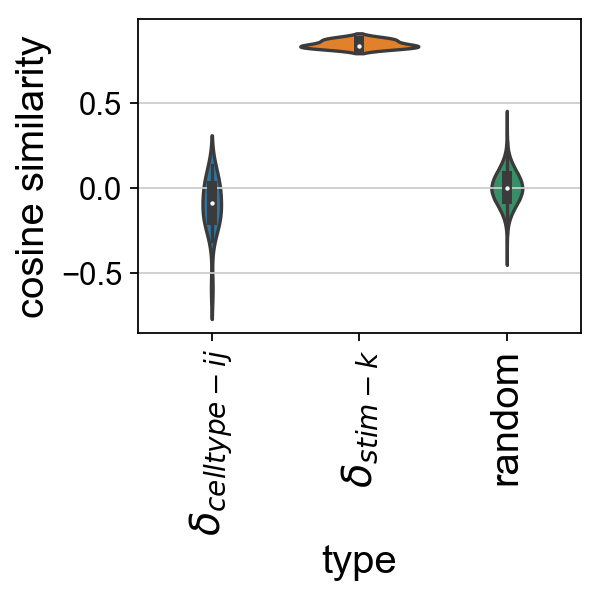

In [74]:
values = np.concatenate([t1.flatten(),h1.flatten(),k.flatten()])
type_val = [r'$\delta_{celltype-ij}$']*len(t1.flatten()) + [r'$\delta_{stim-k}$']*len(h1.flatten()) + \
["random"]*len(k.flatten())
df3 = pd.DataFrame({"cosine similarity"  : values , "type" : type_val})
sns.violinplot(y="cosine similarity", x="type", data=df3)
plt.xticks(rotation=90, fontsize=18)
plt.ylabel("cosine similarity", fontsize=18)
plt.xlabel("type", fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(path_to_save, "SupplFig1c_box_degree_delta_random.pdf"), dpi=300)

In [75]:
df3['type'].value_counts()

random                    499500
$\delta_{celltype-ij}$        21
$\delta_{stim-k}$              7
Name: type, dtype: int64